## Synopsis

This code generates the SAXS 2D and 1D figure (droplet) for the manuscript

## Initialize

In [1]:

import numpy as np
from numpy import sqrt, sin, cos, pi, exp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py  
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from xpcs_viewer import XpcsFile as xf

mpl.rcParams['legend.handlelength'] = 2

## Load result files

In [2]:

fn_path = "/Users/dozgulbas/APS_Data/"
noisy_droplet = "E0098_D100_Pendant_022C_att01_Rq0_00001_0001-100000.hdf"
dropleta = "AvgF084_Pendant_WithCase_Cen_att00_Lq0_Rq0_00001_0001-100000.hdf"
CapCellb = "AvgD129_D100_samy3_Cell_att00_Lq0_Rq0_00001_0001-100000.hdf"
capillaryc = "AvgF091_D100_Capillary_Post_att00_Lq0_Rq0_00001_0001-100000.hdf"

droplet = xf(dropleta, cwd = fn_path)
CapCell = xf(CapCellb, cwd = fn_path)
capillary = xf(capillaryc, cwd = fn_path)
# The value in hdf file is wrong but the q's in Q map is right, as the detector distance was manually corrected
det_dist = 8000   

pix2q = droplet.pix_dim_x/det_dist*(2*3.1416/(12.4/droplet.X_energy))


## Plot 2D SAXS from droplet

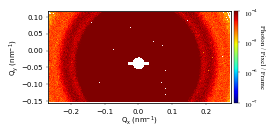

In [3]:

# figure parameter settings. 3.3 inch is about 85 mm
scale = 1
width = 3.4*scale
font_size = 7*scale
line_width = 0.35*scale
tick_length_major = 2*scale
tick_length_minor = 1*scale

# Set up plot range for the 2D image
Q_y_max = (droplet.saxs_2d.shape[0]-droplet.ccd_y0)*pix2q
Q_y_min = -droplet.ccd_y0*pix2q

Q_x_min = (droplet.ccd_x0-droplet.saxs_2d.shape[1])*pix2q
Q_x_max = droplet.ccd_x0*pix2q

###### Plot image ######

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(width, width))
im = ax.imshow(np.rot90(droplet.saxs_2d), cmap='jet', norm=LogNorm(vmin=1e-7, vmax=1e-4),
               interpolation='none', extent=([Q_y_min*10, Q_y_max*10, Q_x_min*10, Q_x_max*10]))

### Define ticks, labels and strokes
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = font_size
plt.xticks(fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.xlabel('Q$\mathdefault{_x}$ (nm$\mathdefault{^{-1}}$)', fontsize=font_size, labelpad=0.05*font_size)
plt.ylabel('Q$\mathdefault{_y}$ (nm$\mathdefault{^{-1}}$)', fontsize=font_size, labelpad=0.05*font_size)
plt.rcParams['axes.linewidth'] = line_width
ax.tick_params('both', length=tick_length_major, width=line_width, which='major')
ax.tick_params('x', length=tick_length_minor, width=0.5*line_width, which='minor')

### Add color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = fig.colorbar(im, cax=cax, ticks=[1e-7, 1e-6, 1e-5, 1e-4])
cbar.ax.tick_params('y', length=tick_length_major, width=line_width, which='major')
cbar.ax.minorticks_off()
cbar.set_label('Photon / Pixel / Frame', rotation=270, labelpad=font_size)

### Save figure
plt.savefig('Int_2D_droplet.pdf', dpi=600, format='pdf', 
            facecolor='w', edgecolor='w', transparent=False, bbox_inches='tight')


## Calculate I(Q) for hard sphere
The fit is eyeballed since there is no explicit function form for I(Q)

In [4]:

I_Corr = 0.92

rad_coeff=np.zeros([2])

I_cal=np.zeros(len(droplet.ql_sta))

R_NP = 135
d_NP = 12

for ii in np.arange(len(droplet.ql_sta)):
    ql = droplet.ql_sta[ii]
    I_size = lambda x: (sin(ql*x)-ql*x*cos(ql*x))**2 / (ql*x)**6*exp(-(x-R_NP)**2/(2*d_NP**2))

    drop = integrate.quad(I_size, 0, 1000)
    I_cal[ii] = drop[0]

Iq_fit = I_Corr*I_cal/np.max(I_cal)*np.max(droplet.saxs_1d['Iq'])    


## Plot 1D SAXS from droplet, CapCell and (NH$_4$)$_2$SO$_4$. 

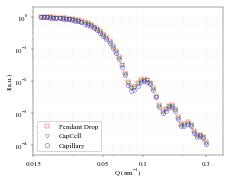

In [17]:

# figure parameter settings. 3.3 inch is about 85 mm
scale = 1
width = 3.4*scale
font_size = 7*scale
line_width = 0.35*scale
marker_size = 4*scale
tick_length_major = 2*scale
tick_length_minor = 1*scale

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(width, 0.8*width))
ax.plot(10*droplet.ql_sta, np.squeeze(droplet.saxs_1d['Iq'])/0.16, color='r', fillstyle='none', 
    marker='s', markersize=marker_size, markevery=5, markeredgewidth=line_width, 
        linestyle="None", label='Pendant Drop')
ax.plot(10*CapCell.ql_sta, np.squeeze(CapCell.saxs_1d['Iq'])/0.105, color='g', fillstyle='none', 
    marker='v', markersize=marker_size, markevery=5, markeredgewidth=line_width,
        linestyle="None", label='CapCell')
ax.plot(10*capillary.ql_sta, np.squeeze(capillary.saxs_1d['Iq'])/0.099, color='b', fillstyle='none', 
    marker='o', markersize=marker_size, markevery=5, markeredgewidth=line_width, 
        linestyle="None", label='Capillary')        
# ax.plot(10*np.squeeze(droplet.ql_sta), Iq_fit, color='b', 
#         linestyle="-", linewidth=line_width*2, label='Hard Sphere Model')

### Define plot range
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1.5e-2, 4e-1)
ax.set_ylim(5e-5, 2)
ax.set_xticks([1.5e-2, 5e-2, 1e-1, 3e-1], fontsize = font_size)
ax.set_xticklabels([0.015, 0.05, 0.1, 0.3], fontsize = font_size)
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
plt.yticks(fontsize = font_size)
# ax.set_yticklabels([1e-5, 1e-4, 1e-3, 1e-2, 1e-1], fontsize = font_size)


### Define ticks, labels and strokes
plt.rcParams["font.family"] = "Times New Roman"
ax.grid(color='k', linestyle='-', linewidth=line_width, alpha=0.05, which='both')
plt.rcParams["font.size"] = font_size
# ax.set_xticks(fontsize = font_size)
# ax.set_yticks(fontsize = font_size)
plt.xlabel('Q (nm$\mathdefault{^{-1}}$)', fontsize=font_size, labelpad=0.05*font_size)
# plt.ylabel('Photon/Pixel/Frame', fontsize=font_size, labelpad=0.05*font_size)
plt.ylabel('I(a.u.)', fontsize=font_size, labelpad=0.05*font_size)


plt.rcParams['axes.linewidth'] = line_width
ax.tick_params('both', length=tick_length_major, width=line_width, which='major')
ax.tick_params('both', length=tick_length_minor, width=0.5*line_width, which='minor')

### Define legend
ax.legend(loc='lower left', prop={'size': font_size})

### Save figure
plt.savefig('/Users/dozgulbas/Desktop/Saxs1D_paper.pdf', dpi=600, format='pdf', 
            facecolor='w', edgecolor='w', transparent=False, bbox_inches='tight')